# Application of Deep Learning on Cancer Images
### 1000-719bMSB MIM UW, Neo Christopher Chung

In this lab, we make a prediction of lung nodules by a deep learning model and explain that decision making process by attention maps and CDAMs. For the simplicity, we provide a pre-trained model and use an existing medical image dataset. To streamline XAI, we are using a Python library called Obz.

## Homework

Train a Vision Transformer model on any of MedMNIST datasets (except NoduleMNIST), followed by prediction and explanation.

Essentially apply the above steps with a different ViT model trained on one of the MedMNIST datasets.



In [1]:
!pip install -q obzai numpy==2.0.0 medmnist captum cmasher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━

We will go through the scenario step by step. Firstly, let's start with doing some imports.

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch
from torch import nn
from tqdm import tqdm
import torch.optim as optim
import time
import os
import numpy as np
import gdown
import matplotlib.pyplot as plt
import random

**Obz package** is designed to monitor your vision models behaviour. In particular it logs *post hoc* explainability maps and might detect outliers. However, first of all you need to define your model which you would like to monitor.  
So, let's define a simple Vision Transformer based on DINO ViT Backbone! Especially for you I have finetuned DINO VIT model on *LIDC-IDRI* dataset. We will utilize it for a tutorial!

In [3]:
def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)

    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA"
output_dir = "tuned_models"
filename = "lidc_dino_s8.pth"
download_weights(url, output_dir, filename)

Downloading...
From (original): https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA
From (redirected): https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA&confirm=t&uuid=11607507-af30-4650-bfa4-5bf699022c52
To: /content/tuned_models/lidc_dino_s8.pth
100%|██████████| 87.4M/87.4M [00:06<00:00, 14.4MB/s]


In [4]:
from transformers import ViTConfig, ViTModel

class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    """
    def __init__(self):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # We propose eager implementation to return att scores gracefully.
        self.backbone = ViTModel(config)
        # Classfication head
        self.head = torch.nn.Linear(384, 1)

    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

In [5]:
# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "./tuned_models/lidc_dino_s8.pth"

MODEL = DINO()
MODEL.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True, map_location=torch.device(DEVICE)))
MODEL = MODEL.to(DEVICE).eval()

# Unfreeze several transformer layers
for param in MODEL.backbone.parameters():
    param.requires_grad = False
for idx in [9, 10, 11]:
    for param in MODEL.backbone.encoder.layer[idx].parameters():
        param.requires_grad = True
for param in MODEL.backbone.pooler.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

Next, let's prepare datasets. You need two source of images! One is **Reference** dataset, which will be used to extract reference image features and fit outlier detection utilities. Second one, **Inference** dataset will act as incoming new data which uou would like to monitor.  
For the tutorial case we will use LIDC-IDRI subset called: **Nodule MNIST**. This dataset is readily available via **MedMNIST** package. If you don't have MedMNIST, please install it with a command below.

In [7]:
from medmnist import VesselMNIST3D

In [8]:
# Aneurysm (class 1) has much less examples, so we will augment it

class AugmentAneurysmWrapper(Dataset):
    def __init__(self, base_dataset, common_transform=None, augment_transform=None, oversample_factor=5):
        self.base_dataset = base_dataset
        self.common_transform = common_transform
        self.augment_transform = augment_transform

        # Split the dataset by class
        self.vessel_samples = [sample for sample in base_dataset if sample[1] == 0]
        self.aneurysm_samples = [sample for sample in base_dataset if sample[1] == 1]

        # Oversample aneurysm samples
        self.oversample_factor = oversample_factor
        self.expanded_aneurysm_samples = self.aneurysm_samples * self.oversample_factor

        # Combine the datasets
        self.full_data = self.vessel_samples + self.expanded_aneurysm_samples

    def __len__(self):
        return len(self.full_data)

    def __getitem__(self, idx):
        x, y = self.full_data[idx]

        # Apply common transform
        if self.common_transform:
            x = self.common_transform(x)

        # Apply augmentation to aneurysm samples
        if y == 1 and self.augment_transform:
            x = self.augment_transform(x)

        return x, y


In [9]:
# Transforms
def take_middle_slice(inpt: np.ndarray):
    """
    NoduleMNIST 3D contains whole nodule volumes, however for this tutorial
    we will utilize only central slice of each example.
    We repeat this slice 3 times, as model expects input to have 3 channels.
    """
    inpt = inpt.squeeze()
    X, Y, Z = inpt.shape
    slice_ = inpt[:, :, Z//2]
    slice_ = torch.Tensor(slice_).unsqueeze(dim=0).repeat(3,1,1)
    return slice_

NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

TRANSFORMS = v2.Compose([
    v2.Lambda(take_middle_slice),
    v2.Resize(size=(224, 224)),
])

COMMON_TRANSFORM = v2.Compose([
    v2.Lambda(take_middle_slice),
    v2.Resize((224, 224))
])

AUGMENT_ANEURYSM = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=15),
    v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05))
])

# Datasets
data_dir = "./example_data"
os.makedirs(data_dir, exist_ok=True)

## Download datasets to train a ViT model
raw_train_set = VesselMNIST3D(root=data_dir, split="train", size=64, transform=lambda x: x, download=True)

train_set = AugmentAneurysmWrapper(
    base_dataset=raw_train_set,
    common_transform=COMMON_TRANSFORM,
    augment_transform=AUGMENT_ANEURYSM
)
## Validation data. We will use it as source of reference statistics and to "train" OutlierDetector.
val_set = VesselMNIST3D(root=data_dir, split="val", size=64, transform=TRANSFORMS, download=True)
## Test data. We will use it as exemplary source of production data.
test_set = VesselMNIST3D(root=data_dir, split="test", size=64, transform=TRANSFORMS)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=6, shuffle=True)

# Labels mapping
CLASS_NAMES = ["vessel", "aneurysm"]

LOGIT2NAME = {
    0: "vessel",
    1: "aneurysm",
}

100%|██████████| 2.65M/2.65M [00:01<00:00, 2.25MB/s]


In [15]:
# Count class frequencies
from collections import Counter

label_counts = Counter([label.item() for _, label in train_set])
num_pos = label_counts[1]
num_neg = label_counts[0]

print(num_pos)
print(num_neg)


750
1185


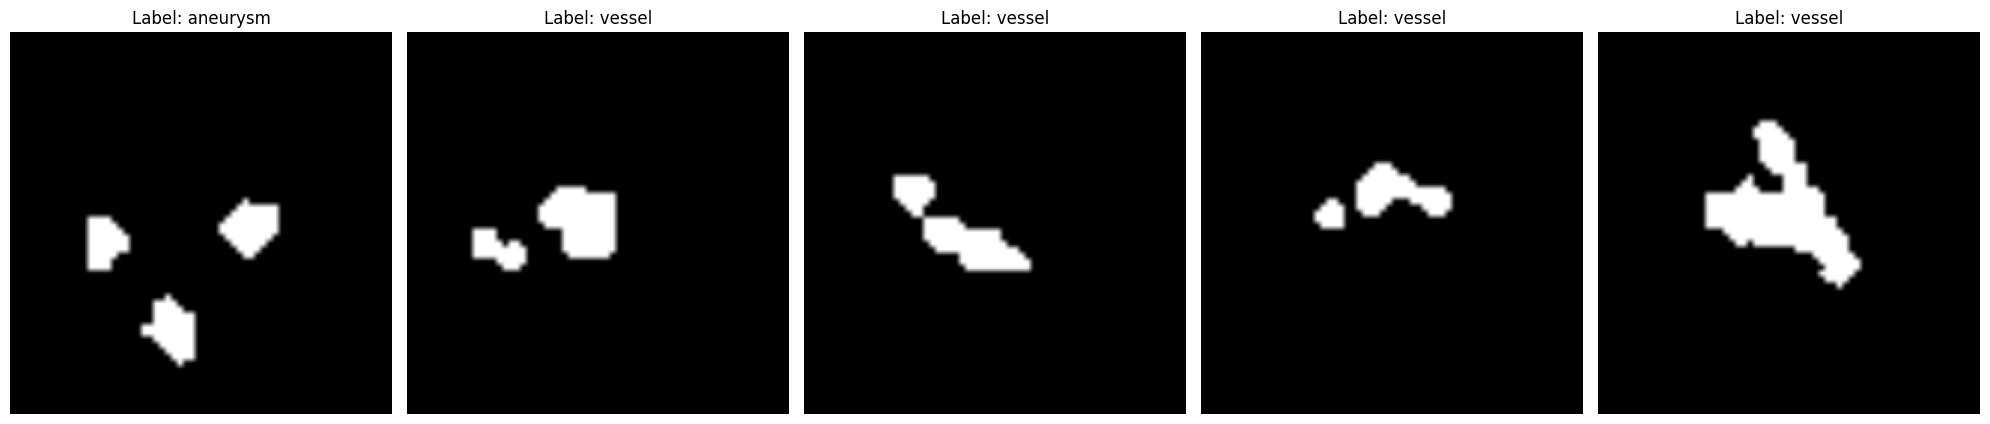

In [10]:
# Visualize the first 5 samples from val_loader
samples, labels = next(iter(val_loader))

# Plot the first 5 samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image = samples[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {CLASS_NAMES[labels[i].item()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Train the pretrained ViT on the new dataset

In [16]:
optimizer = optim.Adam(MODEL.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # minimize validation loss
    factor=0.5,           # reduce LR by a factor of 0.5
    patience=2,
    verbose=True
)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

EPOCHS = 8

def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.long().cpu().numpy())

            correct += (preds.squeeze() == labels.squeeze().long()).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader.dataset)
    acc = correct / total

    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=CLASS_NAMES, zero_division=np.nan))

    return avg_loss, acc

# Training Loop
best_acc = 0.0
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    start = time.time()
    train_loss = train(MODEL, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate(MODEL, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)
    end = time.time()

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
    print(f"Time: {end - start:.2f}s")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(MODEL.state_dict(), "best_vessel_vit.pth")

Epoch 1/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.89      0.98      0.94       169
    aneurysm       0.40      0.09      0.15        22

    accuracy                           0.88       191
   macro avg       0.65      0.54      0.54       191
weighted avg       0.84      0.88      0.84       191

Train Loss: 0.3724
Val Loss: 0.0227 | Val Accuracy: 0.8796
Time: 56.46s
Epoch 2/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.90      0.98      0.94       169
    aneurysm       0.50      0.18      0.27        22

    accuracy                           0.88       191
   macro avg       0.70      0.58      0.60       191
weighted avg       0.86      0.88      0.86       191

Train Loss: 0.1797
Val Loss: 0.0240 | Val Accuracy: 0.8848
Time: 59.53s
Epoch 3/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.88      0.97      0.92       169
    aneurysm       0.00      0.00      0.00        22

    accuracy                           0.86       191
   macro avg       0.44      0.49      0.46       191
weighted avg       0.78      0.86      0.82       191

Train Loss: 0.1105
Val Loss: 0.0313 | Val Accuracy: 0.8586
Time: 59.72s
Epoch 4/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.88      0.99      0.94       169
    aneurysm       0.00      0.00      0.00        22

    accuracy                           0.88       191
   macro avg       0.44      0.50      0.47       191
weighted avg       0.78      0.88      0.83       191

Train Loss: 0.1007
Val Loss: 0.0299 | Val Accuracy: 0.8796
Time: 60.78s
Epoch 5/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.90      0.98      0.94       169
    aneurysm       0.50      0.18      0.27        22

    accuracy                           0.88       191
   macro avg       0.70      0.58      0.60       191
weighted avg       0.86      0.88      0.86       191

Train Loss: 0.0728
Val Loss: 0.0267 | Val Accuracy: 0.8848
Time: 60.81s
Epoch 6/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.89      0.99      0.94       169
    aneurysm       0.50      0.09      0.15        22

    accuracy                           0.88       191
   macro avg       0.70      0.54      0.55       191
weighted avg       0.85      0.88      0.85       191

Train Loss: 0.0572
Val Loss: 0.0293 | Val Accuracy: 0.8848
Time: 61.06s
Epoch 7/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.89      0.99      0.94       169
    aneurysm       0.50      0.05      0.08        22

    accuracy                           0.88       191
   macro avg       0.69      0.52      0.51       191
weighted avg       0.84      0.88      0.84       191

Train Loss: 0.0476
Val Loss: 0.0335 | Val Accuracy: 0.8848
Time: 60.98s
Epoch 8/8


Classification Report:
               precision    recall  f1-score   support

      vessel       0.89      1.00      0.94       169
    aneurysm       1.00      0.05      0.09        22

    accuracy                           0.89       191
   macro avg       0.94      0.52      0.51       191
weighted avg       0.90      0.89      0.84       191

Train Loss: 0.0498
Val Loss: 0.0338 | Val Accuracy: 0.8901
Time: 60.90s


Make the prediction for the visualised 5 samples using the aforementioned MODEL

In [19]:
# Move samples to the appropriate device
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)
print(labels)
print(samples.shape)

# Perform inference using the model
with torch.no_grad():
    logits = MODEL(samples)
    predictions = torch.sigmoid(logits).round().squeeze().cpu().numpy()

# Map predictions to class names
predicted_classes = [LOGIT2NAME[int(pred)] for pred in predictions]

# Print the results
for i, pred_class in enumerate(predicted_classes):
    print(f"Prediction for Sample {i + 1}: {pred_class}")

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
torch.Size([5, 3, 224, 224])
Prediction for Sample 1: vessel
Prediction for Sample 2: vessel
Prediction for Sample 3: vessel
Prediction for Sample 4: vessel
Prediction for Sample 5: vessel


## Extract features for outlier detection

You can use Data Inspector Module and XAI Module locally to detect outliers and compute explainability maps.
You need to instantiate `OutlierDetector` from Data Inspector Module and desired `XAI Tools` from XAI Module.

In [20]:
# Setup OutlierDetector
from obzai.data_inspector.extractor import FirstOrderExtractor
from obzai.data_inspector.detector import GMMDetector
# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=[first_order_extrc], n_components=3, outlier_quantile=0.01)
# Call .fit() method with passed reference dataloader.
# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(val_loader)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a4e4411b6a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


## Explain the AI model

#### We first need to choose and set up appropriate XAI tools.

In [21]:
# Setup XAI Tools
from obzai.xai.xai_tool import CDAM, AttentionMap

# Choose desired XAI Tools
cdam_tool = CDAM(model=MODEL,
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_logits",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=MODEL,
                              attention_layer_id = -1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )

#### Then, we can run the XAI method to our data.
We first apply and visualize attention maps

In [22]:
# Apply attention_tool on the first ten samples
attention_maps = attention_tool.explain(samples)  # Use the appropriate method to generate attention maps

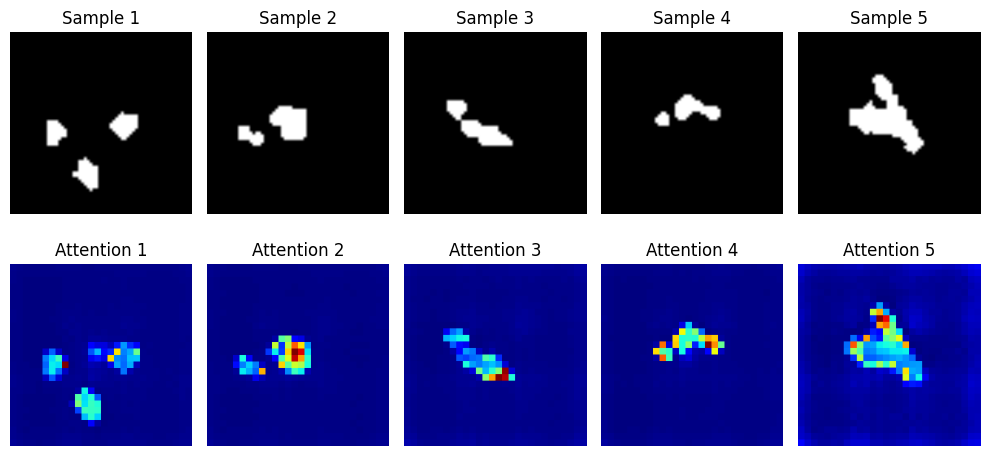

In [23]:
# Visualize samples and attention maps
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Attention maps
for i in range(5):
    attention_map = attention_maps[i].cpu().numpy()
    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

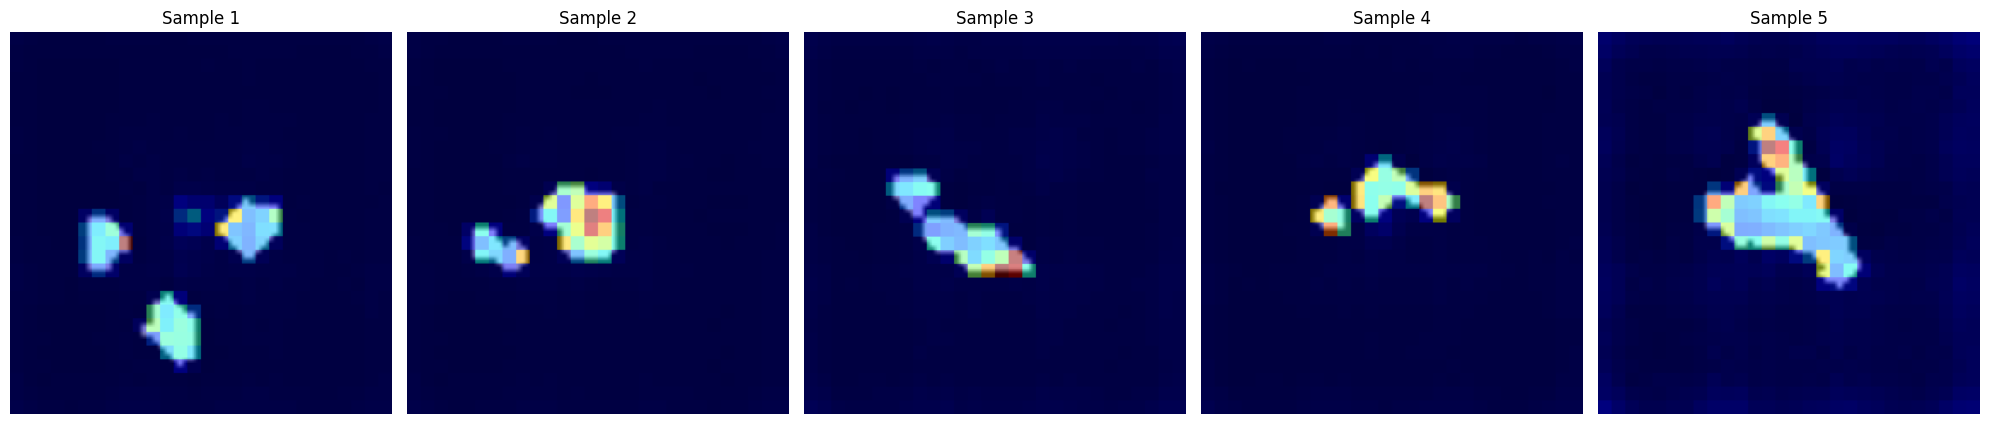

In [24]:
# Visualize attention maps overlaid on samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    attention_map = attention_maps[i].cpu().numpy()  # Convert attention map to numpy array

    # Overlay attention map on the original image
    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)  # Use alpha for transparency
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Generate and visualize CDAM maps

In [25]:
# Generate CDAM maps
cdam_maps = cdam_tool.explain(samples, target_idx=[0,0,0,0,0])  # Use the appropriate method to generate CDAM maps

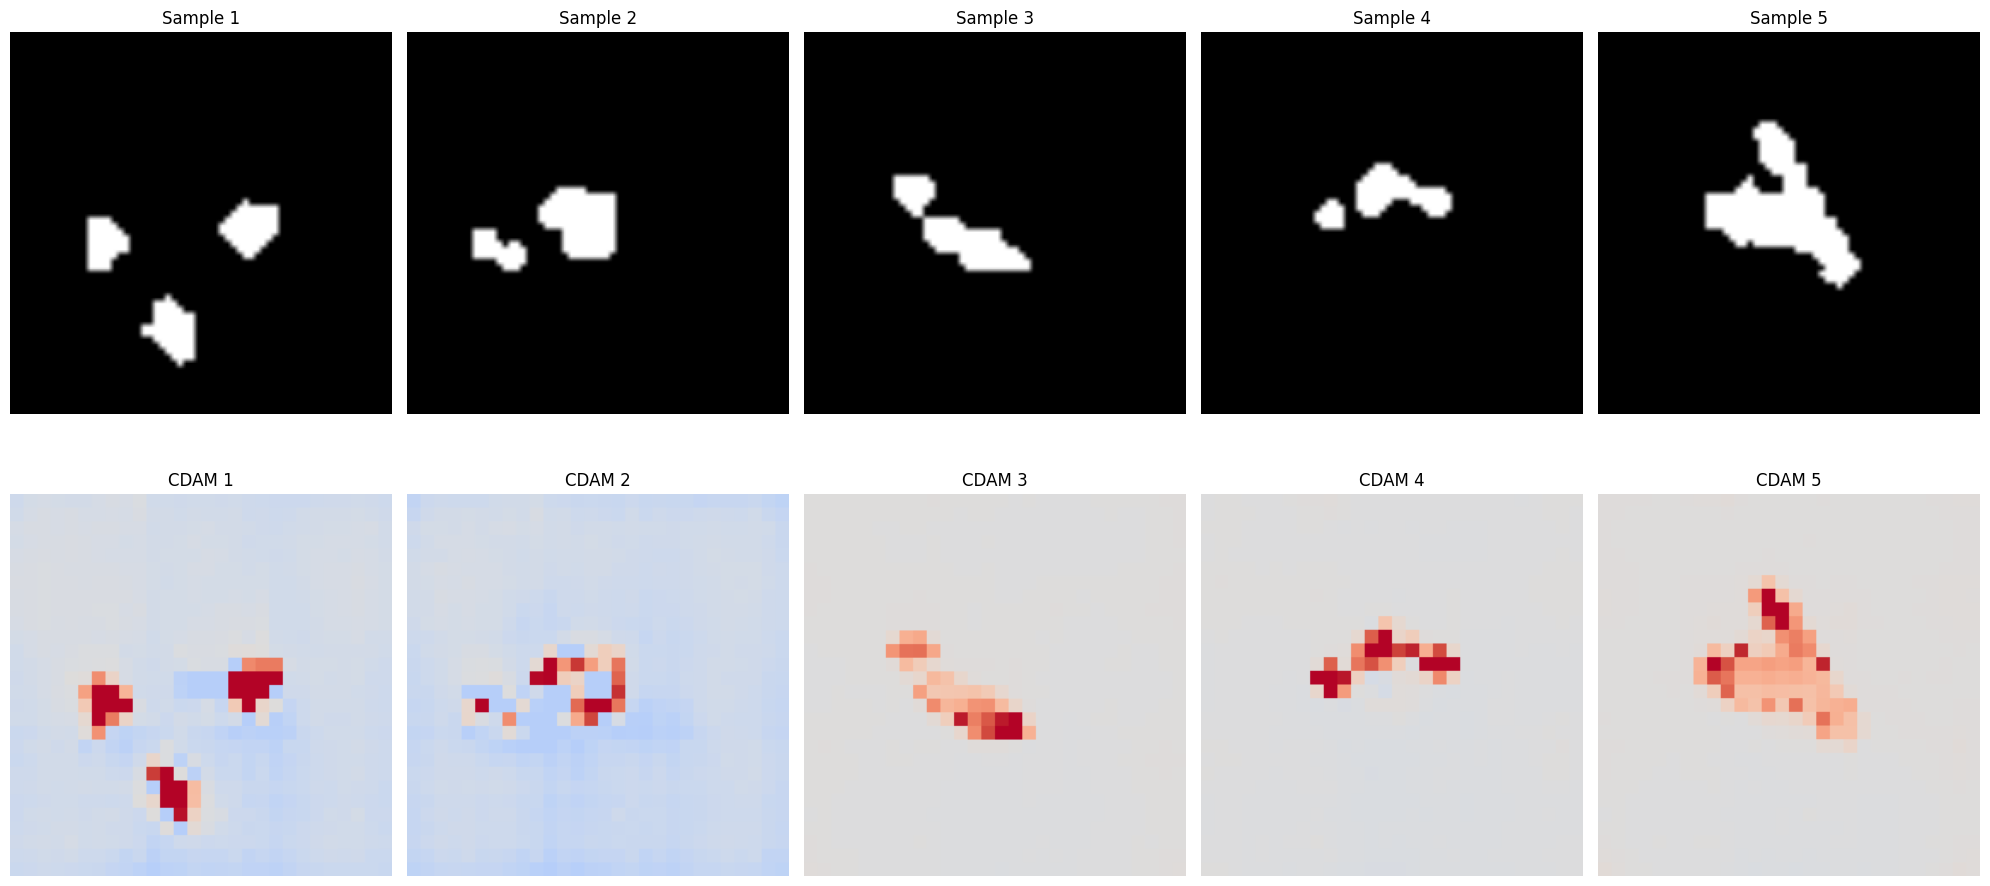

In [26]:
# Visualize samples and CDAM maps
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: CDAM maps
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Diverging colormap
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

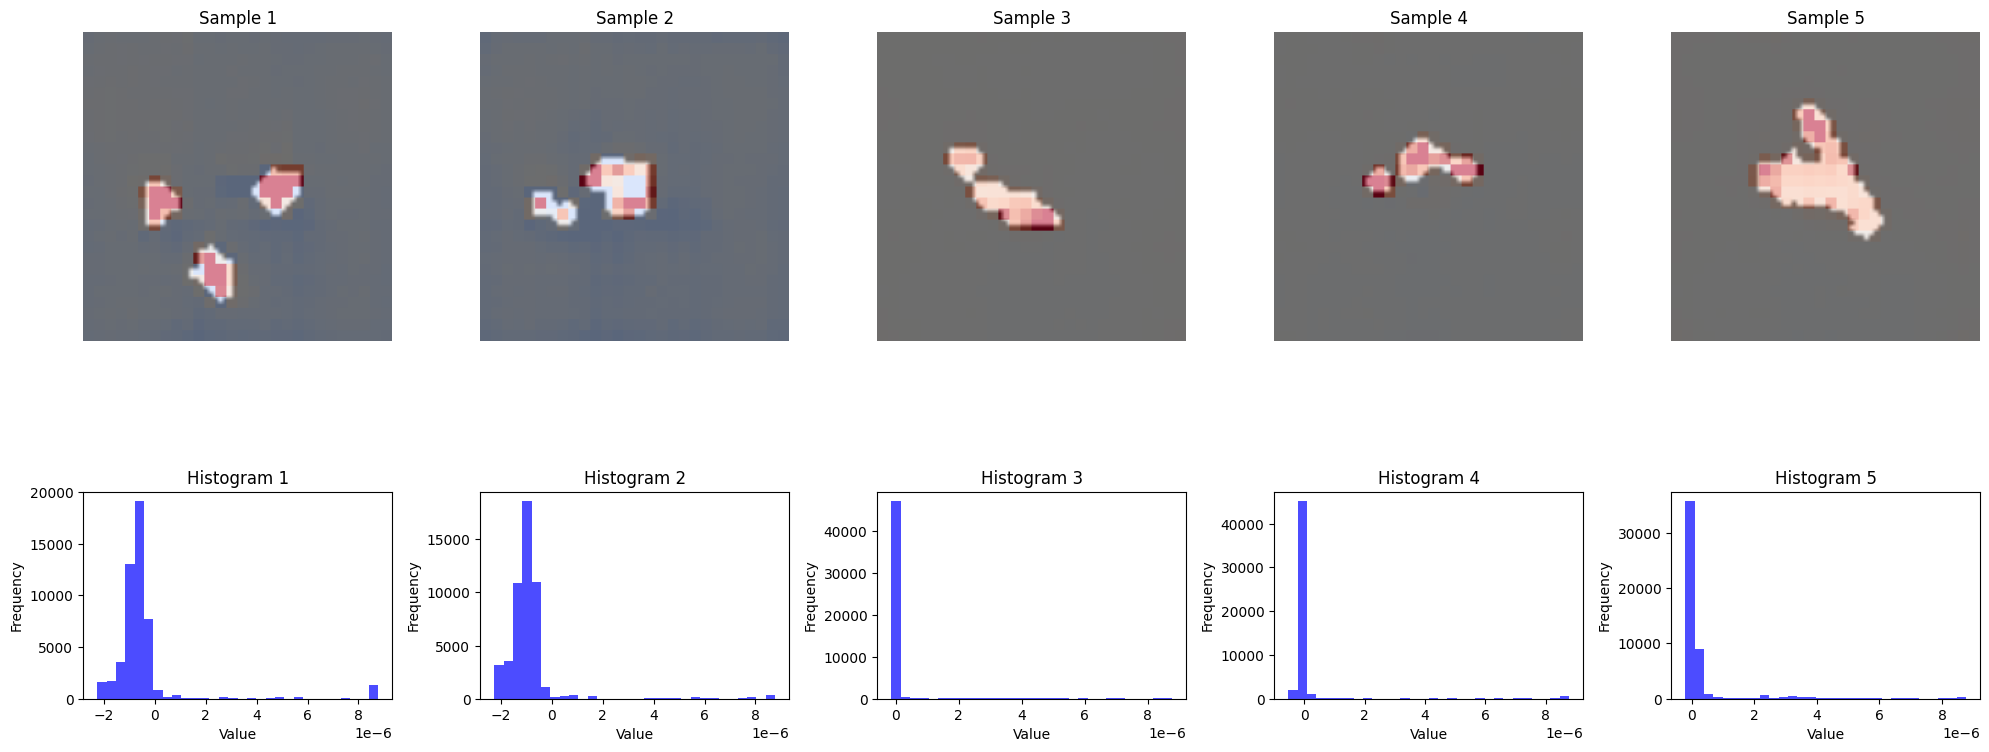

In [27]:
# Visualize CDAM maps overlaid on samples with histogram and color bar
fig, axes = plt.subplots(2, 5, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})

# First row: Original samples with overlaid CDAM maps
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array

    # Overlay CDAM map on the original image
    im = axes[0, i].imshow(original_image, cmap='gray')
    im = axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Use alpha for transparency
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Histogram of CDAM map values
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()